In [1]:
import pandas as pd
import pickle
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

In [2]:
# Unpickling results files
with open('model_results_immune_90.pkl', 'rb') as f:
    model_results_immune_90 = pickle.load(f)

with open('model_results_immune_30.pkl', 'rb') as f:
    model_results_immune_30 = pickle.load(f)

with open('model_results_all_90.pkl', 'rb') as f:
    model_results_all_90 = pickle.load(f)

with open('model_results_all_30.pkl', 'rb') as f:
    model_results_all_30 = pickle.load(f)

with open ('model_results_labs_90.pkl', 'rb') as f:
    model_results_labs_90 = pickle.load(f)

with open ('model_results_labs_30.pkl', 'rb') as f:
    model_results_labs_30 = pickle.load(f)

/Users/roshan/miniconda3/envs/datathon25/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:55:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1727634913186/work/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


**90-day mortality; immune features**

In [3]:
# Printing results
for model in model_results_immune_90.keys():
    print(model)
    print(model_results_immune_90[model]['metrics'])

XGB
{'accuracy': 0.6683804627249358, 'f1': 0.37681159420289856, 'precision': 0.26, 'recall': 0.6842105263157895, 'rel_impr_accuracy': -0.216867469879518, 'rel_impr_f1': 376811594202.89856}
KNN
{'accuracy': 0.7660668380462725, 'f1': 0.2222222222222222, 'precision': 0.21666666666666667, 'recall': 0.22807017543859648, 'rel_impr_accuracy': -0.10240963855421684, 'rel_impr_f1': 222222222222.22223}
SVC Linear
{'accuracy': 0.7712082262210797, 'f1': 0.40268456375838924, 'precision': 0.32608695652173914, 'recall': 0.5263157894736842, 'rel_impr_accuracy': -0.09638554216867475, 'rel_impr_f1': 402684563758.3892}
SVC RBF
{'accuracy': 0.6632390745501285, 'f1': 0.38497652582159625, 'precision': 0.26282051282051283, 'recall': 0.7192982456140351, 'rel_impr_accuracy': -0.22289156626506024, 'rel_impr_f1': 384976525821.59625}
SVC Poly
{'accuracy': 0.6580976863753213, 'f1': 0.3248730964467005, 'precision': 0.22857142857142856, 'recall': 0.5614035087719298, 'rel_impr_accuracy': -0.22891566265060245, 'rel_imp

In [4]:
# SVC Linear had the best f1 Score
my_model = model_results_immune_90['SVC Linear']
best_model= my_model['best_model']
svc = best_model.named_steps['model']

# Get coefficients
coefs = svc.coef_.ravel()

# Get feature names from the preprocessor
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Combine into a DataFrame
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': coefs
}).sort_values(by='importance', key=abs, ascending=False)

print(importances)

                          feature  importance
2  num__Absolute Lymphocyte Count   -1.521034
0                       num__SIRI    0.702916
1    num__Absolute Monocyte Count    0.252339
3  num__Absolute Neutrophil Count    0.050005


In [5]:
# SVC RBF had the best recall
my_model = model_results_immune_90['SVC RBF']
best_model= my_model['best_model']
X_test = my_model['X_test_raw']
y_test = my_model['y_test']

# Compute permutation importance
results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
print(len(results.importances_mean))

# Combine feature names and importance
importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances.head(20))

4
                     feature  importance_mean  importance_std
0                       SIRI         0.079949        0.015185
1    Absolute Monocyte Count         0.069152        0.010934
3  Absolute Neutrophil Count         0.045501        0.015554
2  Absolute Lymphocyte Count        -0.013625        0.009343


**90-day mortality; all features**

In [6]:
# Printing results
for model in model_results_all_90.keys():
    print(model)
    print(model_results_all_90[model]['metrics'])

XGB
{'accuracy': 0.7892030848329049, 'f1': 0.4533333333333333, 'precision': 0.3655913978494624, 'recall': 0.5964912280701754, 'rel_impr_accuracy': -0.07530120481927707, 'rel_impr_f1': 453333333333.3333}
KNN
{'accuracy': 0.8380462724935732, 'f1': 0.35051546391752575, 'precision': 0.425, 'recall': 0.2982456140350877, 'rel_impr_accuracy': -0.018072289156626554, 'rel_impr_f1': 350515463917.52576}
SVC Linear
{'accuracy': 0.7300771208226221, 'f1': 0.45595854922279794, 'precision': 0.3235294117647059, 'recall': 0.7719298245614035, 'rel_impr_accuracy': -0.14457831325301204, 'rel_impr_f1': 455958549222.798}
SVC RBF
{'accuracy': 0.7712082262210797, 'f1': 0.47337278106508873, 'precision': 0.35714285714285715, 'recall': 0.7017543859649122, 'rel_impr_accuracy': -0.09638554216867475, 'rel_impr_f1': 473372781065.08875}
SVC Poly
{'accuracy': 0.7326478149100257, 'f1': 0.45263157894736844, 'precision': 0.3233082706766917, 'recall': 0.7543859649122807, 'rel_impr_accuracy': -0.14156626506024092, 'rel_impr

In [7]:
# SVC RBF had the best f1 score
my_model = model_results_all_90['SVC RBF']
best_model= my_model['best_model']
X_test = my_model['X_test_raw']
y_test = my_model['y_test']

# Compute permutation importance
results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
print(len(results.importances_mean))

# Combine feature names and importance
importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances.head(20))


35
                      feature  importance_mean  importance_std
27                    Lactate         0.029820        0.002863
32                       SIRI         0.013625        0.006806
5              marital_status         0.011054        0.003822
33              Urea Nitrogen         0.009254        0.005996
28                        PTT         0.008226        0.004712
20                 Creatinine         0.006427        0.004340
3                   insurance         0.006170        0.005656
19                Bicarbonate         0.005913        0.004309
30                        RDW         0.004884        0.008326
25      Immature Granulocytes         0.004884        0.003138
24                    INR(PT)         0.004370        0.003053
8                  anchor_age         0.003599        0.003292
12    Absolute Basophil Count         0.003599        0.002356
6                        race         0.002314        0.002425
29             Platelet Count         0.001542      

In [8]:
# SVC Linear had the best f1 score
my_model = model_results_all_30['SVC Linear']
best_model= my_model['best_model']
svc = best_model.named_steps['model']

# Get coefficients
coefs = svc.coef_.ravel()

# Get feature names from the preprocessor
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Combine into a DataFrame
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': coefs
}).sort_values(by='importance', key=abs, ascending=False)

print(importances)

                                               feature  importance
371  cat__last_careunit_Cardiac Vascular Intensive ...   -0.371053
359  cat__first_careunit_Cardiac Vascular Intensive...   -0.371053
19                                            num__RDW    0.248041
16                                        num__Lactate    0.247997
6                                       num__Anion Gap    0.218902
..                                                 ...         ...
149                      cat__admit_provider_id_P443HK    0.000000
338              cat__race_HISPANIC/LATINO - COLUMBIAN    0.000000
142                      cat__admit_provider_id_P42J7P    0.000000
135                      cat__admit_provider_id_P40N2M    0.000000
171                      cat__admit_provider_id_P525W5    0.000000

[383 rows x 2 columns]


In [9]:
# SVC Linear had the best recall
my_model = model_results_all_90['SVC Linear']
best_model= my_model['best_model']
X_test = my_model['X_test_raw']
y_test = my_model['y_test']

# Compute permutation importance
results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
print(len(results.importances_mean))

# Combine feature names and importance
importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances.head(20))

35
                      feature  importance_mean  importance_std
27                    Lactate         0.035476        0.010649
5              marital_status         0.013882        0.005885
24                    INR(PT)         0.005656        0.002519
32                       SIRI         0.005141        0.006604
29             Platelet Count         0.004113        0.004482
7                      gender         0.004113        0.004482
20                 Creatinine         0.002828        0.006132
8                  anchor_age         0.001285        0.005300
0              admission_type         0.000514        0.005490
23                          I         0.000257        0.001384
11                        los         0.000000        0.000000
19                Bicarbonate        -0.000514        0.003949
25      Immature Granulocytes        -0.000771        0.004606
17                  Anion Gap        -0.001028        0.006212
14  Absolute Lymphocyte Count        -0.001028      

**90-day mortality; lab + demographic features only**

In [10]:
# Printing results
for model in model_results_labs_90.keys():
    print(model)
    print(model_results_labs_90[model]['metrics'])

XGB
{'accuracy': 0.8123393316195373, 'f1': 0.44274809160305345, 'precision': 0.3918918918918919, 'recall': 0.5087719298245614, 'rel_impr_accuracy': -0.0481927710843373, 'rel_impr_f1': 442748091603.05347}
KNN
{'accuracy': 0.8020565552699229, 'f1': 0.3185840707964602, 'precision': 0.32142857142857145, 'recall': 0.3157894736842105, 'rel_impr_accuracy': -0.06024096385542163, 'rel_impr_f1': 318584070796.4602}
SVC Linear
{'accuracy': 0.7275064267352185, 'f1': 0.4536082474226804, 'precision': 0.32116788321167883, 'recall': 0.7719298245614035, 'rel_impr_accuracy': -0.14759036144578316, 'rel_impr_f1': 453608247422.6804}
SVC RBF
{'accuracy': 0.7429305912596401, 'f1': 0.4318181818181818, 'precision': 0.31932773109243695, 'recall': 0.6666666666666666, 'rel_impr_accuracy': -0.1295180722891566, 'rel_impr_f1': 431818181818.1818}
SVC Poly
{'accuracy': 0.7557840616966581, 'f1': 0.4632768361581921, 'precision': 0.3416666666666667, 'recall': 0.7192982456140351, 'rel_impr_accuracy': -0.11445783132530117, 

In [11]:
# SVC Poly had the best f1 score
my_model = model_results_labs_90['SVC Poly']
best_model= my_model['best_model']
X_test = my_model['X_test_raw']
y_test = my_model['y_test']

# Compute permutation importance
results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
print(len(results.importances_mean))

# Combine feature names and importance
importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances.head(20))

35
                      feature  importance_mean  importance_std
20                 Creatinine         0.008740        0.002622
22                 Hemoglobin         0.004884        0.003342
27                    Lactate         0.004884        0.003890
29             Platelet Count         0.004627        0.003949
31            Red Blood Cells         0.002828        0.004216
7                      gender         0.001028        0.001705
16  Absolute Neutrophil Count         0.001028        0.002622
28                        PTT         0.000514        0.005116
11                        los         0.000000        0.000000
1           admit_provider_id         0.000000        0.000000
0              admission_type         0.000000        0.000000
10              last_careunit         0.000000        0.000000
4                    language         0.000000        0.000000
2          admission_location         0.000000        0.000000
3                   insurance         0.000000      

In [12]:
# SVC Linear had the best recall
my_model = model_results_labs_90['SVC Linear']
best_model= my_model['best_model']
svc = best_model.named_steps['model']

# Get coefficients
coefs = svc.coef_.ravel()

# Get feature names from the preprocessor
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Combine into a DataFrame
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': coefs
}).sort_values(by='importance', key=abs, ascending=False)

print(importances)

                                              feature  importance
39           cat__race_HISPANIC/LATINO - PUERTO RICAN    1.426539
32                       cat__race_BLACK/CAPE VERDEAN    1.204929
25                                    cat__race_ASIAN   -1.188968
33                   cat__race_BLACK/CARIBBEAN ISLAND   -1.062016
30                            cat__race_BLACK/AFRICAN    1.061551
50                 cat__race_WHITE - EASTERN EUROPEAN   -0.959189
24            cat__race_AMERICAN INDIAN/ALASKA NATIVE   -0.918173
44                               cat__race_PORTUGUESE   -0.811635
35              cat__race_HISPANIC/LATINO - DOMINICAN    0.739770
46                         cat__race_UNABLE TO OBTAIN    0.704331
27                          cat__race_ASIAN - CHINESE    0.690126
29                 cat__race_ASIAN - SOUTH EAST ASIAN    0.633888
19                                           num__RDW    0.588982
38                cat__race_HISPANIC/LATINO - MEXICAN   -0.586038
36        

**30-day mortality; immune features**

In [13]:
# Printing results
for model in model_results_immune_30.keys():
    print(model)
    print(model_results_immune_30[model]['metrics'])

XGB
{'accuracy': 0.6786632390745502, 'f1': 0.4131455399061033, 'precision': 0.2913907284768212, 'recall': 0.7096774193548387, 'rel_impr_accuracy': -0.19266055045871552, 'rel_impr_f1': 413145539906.10333}
KNN
{'accuracy': 0.781491002570694, 'f1': 0.3511450381679389, 'precision': 0.3333333333333333, 'recall': 0.3709677419354839, 'rel_impr_accuracy': -0.07033639143730891, 'rel_impr_f1': 351145038167.9389}
SVC Linear
{'accuracy': 0.7994858611825193, 'f1': 0.38095238095238093, 'precision': 0.375, 'recall': 0.3870967741935484, 'rel_impr_accuracy': -0.04892966360856265, 'rel_impr_f1': 380952380952.3809}
SVC RBF
{'accuracy': 0.7069408740359897, 'f1': 0.3595505617977528, 'precision': 0.27586206896551724, 'recall': 0.5161290322580645, 'rel_impr_accuracy': -0.15902140672782875, 'rel_impr_f1': 359550561797.7528}
SVC Poly
{'accuracy': 0.6195372750642674, 'f1': 0.3884297520661157, 'precision': 0.2611111111111111, 'recall': 0.7580645161290323, 'rel_impr_accuracy': -0.2629969418960244, 'rel_impr_f1': 

In [14]:
# XGB had the best f1 score
my_model = model_results_immune_30['XGB']
best_model= my_model['best_model']

xgb_clf = best_model.named_steps['model']
xgb_importances = xgb_clf.feature_importances_

transformer = best_model.named_steps['preprocessor']
feature_names = transformer.get_feature_names_out()

import pandas as pd

importances = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': xgb_importances
    })
    .sort_values(by='importance', ascending=False)
)

print(importances.head(20))

                          feature  importance
2  num__Absolute Lymphocyte Count    0.344072
0                       num__SIRI    0.244156
3  num__Absolute Neutrophil Count    0.229396
1    num__Absolute Monocyte Count    0.182376


In [15]:
# SVC Poly had the best recall
my_model = model_results_immune_30['SVC Poly']
best_model= my_model['best_model']
X_test = my_model['X_test_raw']
y_test = my_model['y_test']

# Compute permutation importance
results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
print(len(results.importances_mean))

# Combine feature names and importance
importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances.head(20))


4
                     feature  importance_mean  importance_std
1    Absolute Monocyte Count         0.050643        0.012701
2  Absolute Lymphocyte Count         0.036761        0.018575
3  Absolute Neutrophil Count         0.019023        0.014998
0                       SIRI         0.011568        0.019246


**30-day mortality; all features**

In [16]:
# Printing results
for model in model_results_all_30.keys():
    print(model)
    print(model_results_all_30[model]['metrics'])

XGB
{'accuracy': 0.7840616966580977, 'f1': 0.5384615384615384, 'precision': 0.4083333333333333, 'recall': 0.7903225806451613, 'rel_impr_accuracy': -0.06727828746177371, 'rel_impr_f1': 538461538461.53845}
KNN
{'accuracy': 0.8251928020565553, 'f1': 0.2765957446808511, 'precision': 0.40625, 'recall': 0.20967741935483872, 'rel_impr_accuracy': -0.018348623853210927, 'rel_impr_f1': 276595744680.8511}
SVC Linear
{'accuracy': 0.7506426735218509, 'f1': 0.5174129353233831, 'precision': 0.37410071942446044, 'recall': 0.8387096774193549, 'rel_impr_accuracy': -0.10703363914373089, 'rel_impr_f1': 517412935323.38306}
SVC RBF
{'accuracy': 0.794344473007712, 'f1': 0.5555555555555556, 'precision': 0.423728813559322, 'recall': 0.8064516129032258, 'rel_impr_accuracy': -0.055045871559633044, 'rel_impr_f1': 555555555555.5555}
SVC Poly
{'accuracy': 0.7506426735218509, 'f1': 0.5221674876847291, 'precision': 0.375886524822695, 'recall': 0.8548387096774194, 'rel_impr_accuracy': -0.10703363914373089, 'rel_impr_f

In [17]:
# SVC (RBF) had the best f1 score
my_model = model_results_all_30['SVC RBF']
best_model= my_model['best_model']
X_test = my_model['X_test_raw']
y_test = my_model['y_test']

# Compute permutation importance
results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
print(len(results.importances_mean))

# Combine feature names and importance
importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances.head(20))


35
                      feature  importance_mean  importance_std
19                Bicarbonate         0.015167        0.003716
29             Platelet Count         0.014396        0.005417
27                    Lactate         0.013882        0.006212
33              Urea Nitrogen         0.011311        0.005996
34                        pO2         0.008997        0.004185
8                  anchor_age         0.008483        0.005148
25      Immature Granulocytes         0.007712        0.006083
30                        RDW         0.007712        0.004740
3                   insurance         0.006427        0.004340
12    Absolute Basophil Count         0.006427        0.003302
7                      gender         0.005913        0.002584
28                        PTT         0.005656        0.004850
9              first_careunit         0.005656        0.006974
10              last_careunit         0.005656        0.006974
15    Absolute Monocyte Count         0.004627      

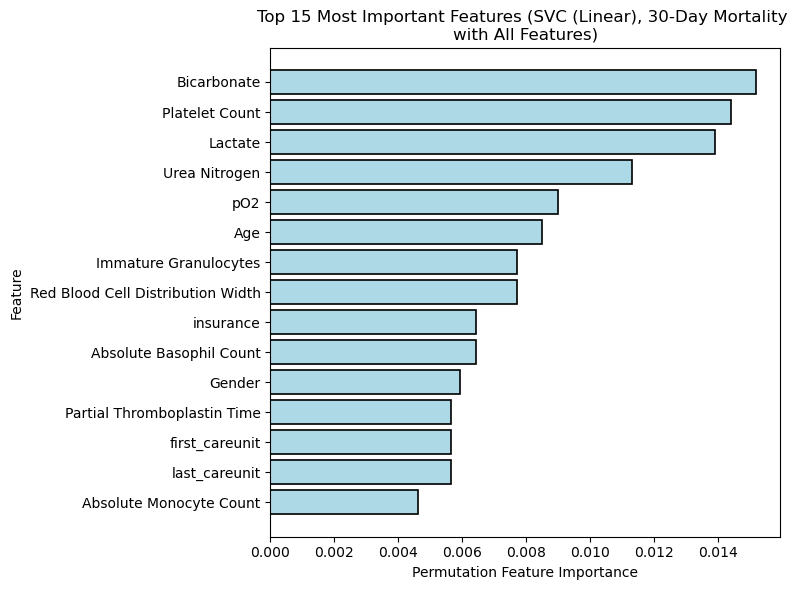

In [18]:
import matplotlib.pyplot as plt
top_feats = importances.head(15).iloc[::-1]  # reversed for better display
rename_map = {
    'anchor_age': 'Age',
    'I': 'Icterus',
    'PTT': 'Partial Thromboplastin Time',
    'gender': 'Gender',
    'admit_provider_id': 'Provider',
    'INR(PT)': 'International Normalized Ratio',
    'RDW': 'Red Blood Cell Distribution Width',
    'H': 'Hemolysis'
}
top_feats['feature'] = top_feats['feature'].replace(rename_map)

plt.figure(figsize=(8, 6))
plt.barh(
    top_feats['feature'],
    top_feats['importance_mean'],
    color='lightblue',
    edgecolor='black',    
    linewidth=1.2,
    capsize=4              
)

plt.xlabel('Permutation Feature Importance')
plt.ylabel('Feature')
plt.title('Top 15 Most Important Features (SVC (Linear), 30-Day Mortality \nwith All Features)')
plt.tight_layout()
plt.savefig('svcrbfall_perm_imps.png')
plt.show()

In [19]:
# SVC Poly. had the best recall
my_model = model_results_all_30['SVC Poly']
best_model= my_model['best_model']
X_test = my_model['X_test_raw']
y_test = my_model['y_test']

# Compute permutation importance
results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
print(len(results.importances_mean))

# Combine feature names and importance
importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances.head(20))

35
                      feature  importance_mean  importance_std
27                    Lactate         0.007455        0.004216
33              Urea Nitrogen         0.006427        0.005777
19                Bicarbonate         0.005913        0.006196
25      Immature Granulocytes         0.002828        0.004519
3                   insurance         0.001542        0.003487
23                          I         0.001285        0.004185
4                    language         0.000514        0.001542
32                       SIRI         0.000514        0.002519
29             Platelet Count         0.000257        0.002135
11                        los         0.000000        0.000000
16  Absolute Neutrophil Count         0.000000        0.001626
14  Absolute Lymphocyte Count         0.000000        0.000000
7                      gender         0.000000        0.000000
6                        race        -0.000771        0.002314
21                          H        -0.000771      

**30-day mortality; lab + demographic features only**

In [20]:
# Printing results
for model in model_results_labs_30.keys():
    print(model)
    print(model_results_labs_30[model]['metrics'])

XGB
{'accuracy': 0.7634961439588689, 'f1': 0.5353535353535354, 'precision': 0.3897058823529412, 'recall': 0.8548387096774194, 'rel_impr_accuracy': -0.09174311926605502, 'rel_impr_f1': 535353535353.5354}
KNN
{'accuracy': 0.7994858611825193, 'f1': 0.2641509433962264, 'precision': 0.3181818181818182, 'recall': 0.22580645161290322, 'rel_impr_accuracy': -0.04892966360856265, 'rel_impr_f1': 264150943396.2264}
SVC Linear
{'accuracy': 0.7892030848329049, 'f1': 0.5393258426966292, 'precision': 0.41379310344827586, 'recall': 0.7741935483870968, 'rel_impr_accuracy': -0.06116207951070331, 'rel_impr_f1': 539325842696.6292}
SVC RBF
{'accuracy': 0.7043701799485861, 'f1': 0.5021645021645021, 'precision': 0.3431952662721893, 'recall': 0.9354838709677419, 'rel_impr_accuracy': -0.16207951070336393, 'rel_impr_f1': 502164502164.50214}
SVC Poly
{'accuracy': 0.7609254498714653, 'f1': 0.5230769230769231, 'precision': 0.38345864661654133, 'recall': 0.8225806451612904, 'rel_impr_accuracy': -0.09480122324159022,

In [21]:
# SVC Linear had the best f1 score
my_model = model_results_labs_30['SVC Linear']
best_model= my_model['best_model']
svc = best_model.named_steps['model']

# Get coefficients
coefs = svc.coef_.ravel()

# Get feature names from the preprocessor
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Combine into a DataFrame
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': coefs
}).sort_values(by='importance', key=abs, ascending=False)

print(importances)

                                              feature  importance
19                                           num__RDW    0.197284
22                                 num__Urea Nitrogen    0.181568
6                                      num__Anion Gap    0.166158
23                                           num__pO2   -0.144856
0                                     num__anchor_age    0.117636
2                      num__Absolute Eosinophil Count   -0.116484
16                                       num__Lactate    0.113031
8                                    num__Bicarbonate   -0.109115
17                                           num__PTT    0.099516
21                                          num__SIRI    0.080677
10                                             num__H    0.077389
15                                             num__L    0.077351
14                         num__Immature Granulocytes    0.076981
1                        num__Absolute Basophil Count   -0.062801
12        

In [22]:
# SVC Linear had the best f1 score (Permutation Importance)
my_model = model_results_labs_30['SVC Linear']
best_model= my_model['best_model']
X_test = my_model['X_test_raw']
y_test = my_model['y_test']

# Compute permutation importance
results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
print(len(results.importances_mean))

# Combine feature names and importance
svclin_importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(svclin_importances.head(20))

35
                      feature  importance_mean  importance_std
33              Urea Nitrogen         0.012339        0.008113
27                    Lactate         0.007455        0.008714
32                       SIRI         0.006684        0.005771
24                    INR(PT)         0.005656        0.002769
12    Absolute Basophil Count         0.005656        0.003410
15    Absolute Monocyte Count         0.003856        0.003497
16  Absolute Neutrophil Count         0.003856        0.004185
13  Absolute Eosinophil Count         0.002571        0.002816
21                          H         0.002314        0.004663
29             Platelet Count         0.002057        0.002769
6                        race         0.001799        0.002008
23                          I         0.001542        0.003292
8                  anchor_age         0.001285        0.007473
28                        PTT         0.001285        0.006826
20                 Creatinine         0.000257      

In [23]:
# SVC RBF had the best recall
my_model = model_results_labs_30['SVC RBF']
best_model= my_model['best_model']
X_test = my_model['X_test_raw']
y_test = my_model['y_test']

# Compute permutation importance
results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
print(len(results.importances_mean))

# Combine feature names and importance
svc_importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(svc_importances.head(20))

35
                      feature  importance_mean  importance_std
33              Urea Nitrogen         0.014910        0.005368
32                       SIRI         0.013111        0.004216
19                Bicarbonate         0.011054        0.006998
17                  Anion Gap         0.009512        0.008452
27                    Lactate         0.008997        0.004775
23                          I         0.005913        0.003459
16  Absolute Neutrophil Count         0.005141        0.003252
24                    INR(PT)         0.004884        0.004216
30                        RDW         0.003856        0.008849
12    Absolute Basophil Count         0.003599        0.003672
18                Base Excess         0.002314        0.003716
21                          H         0.002057        0.003211
8                  anchor_age         0.001285        0.007818
7                      gender         0.000257        0.002425
1           admit_provider_id         0.000000      

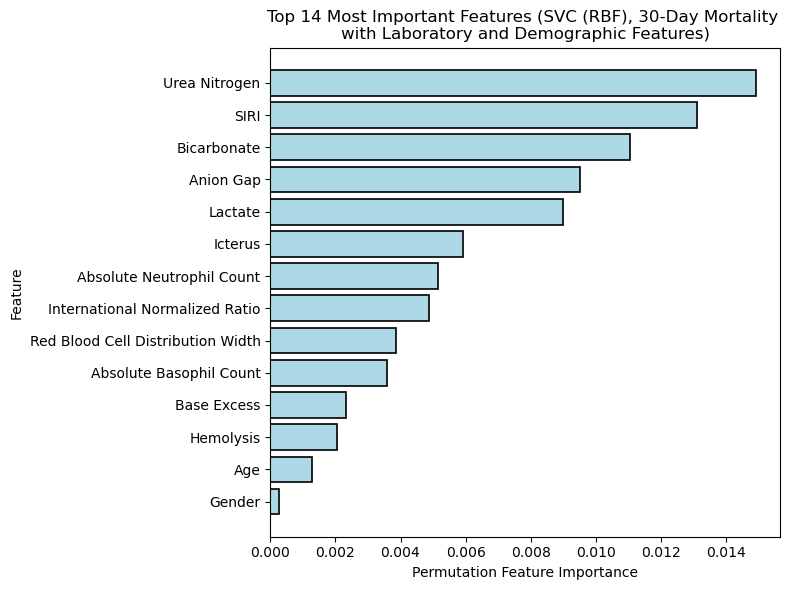

In [24]:
# Get top 14 features (only 14 were non-zero)
top_feats = svc_importances.head(14).iloc[::-1]  # reversed for better display
rename_map = {
    'anchor_age': 'Age',
    'los': 'Length of Stay',
    'I': 'Icterus',
    'PTT': 'Partial Thromboplastin Time',
    'gender': 'Gender',
    'admit_provider_id': 'Provider',
    'INR(PT)': 'International Normalized Ratio',
    'RDW': 'Red Blood Cell Distribution Width',
    'H': 'Hemolysis'
}
top_feats['feature'] = top_feats['feature'].replace(rename_map)

plt.figure(figsize=(8, 6))
plt.barh(
    top_feats['feature'],
    top_feats['importance_mean'],
    color='lightblue',
    edgecolor='black',    
    linewidth=1.2,
    capsize=4              
)

plt.xlabel('Permutation Feature Importance')
plt.ylabel('Feature')
plt.title('Top 14 Most Important Features (SVC (RBF), 30-Day Mortality \nwith Laboratory and Demographic Features)')
plt.tight_layout()
plt.savefig('svcrbf_perm_imps.png')
plt.show()